#Preparation

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install scikit-survival==0.20.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5084c527dbe729cfc34f3e5959d9848ccb142e88306d33a5aa0f0df1bce0b102
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
from sklearn.utils import resample
from lifelines.utils import concordance_index

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
# Read datasets needed (if using local files)
from google.colab import files
uploaded = files.upload()

In [ ]:
# Read datasets needed (if using local files)
import io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read datasets needed (if using google drive
snuh_with_NaN = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_SNUH_with_NaNs.csv')
proact_with_NaN = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_with_NaNs.csv')

In [ ]:
snuh_with_NaN.drop(['Unnamed: 0', 'SubjectID','slope_fvc', 'slope_creatinine', 'slope_weight'], axis = 1, inplace = True)
proact_with_NaN.drop(['Unnamed: 0', 'SubjectID','slope_fvc', 'slope_creatinine', 'slope_weight'], axis = 1, inplace = True)

In [ ]:
all_features_list = list(proact_with_NaN.columns)[:-2]

In [ ]:
print(all_features_list)

['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site', 'diag_minus_onset', 'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting', 'mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs', 'mean_ALSFRS_R_Total', 'mean_R1_Dyspnea', 'mean_R2_Orthopnea', 'mean_R3_Respiratory_Insufficiency', 'mean_Q5_Cutting', 'mean_bulbar', 'mean_motor', 'mean_respiratory_R', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_ALSFRS_R_Total', 'slope_R1_Dyspnea', 'slope_R2_Orthopnea', 'slope_R3_Respiratory_Insufficiency', 'slope_Q5_Cutting', 'slope_bulbar', 'slope_motor', 'slope_respiratory_R', 'mean_fvc', 'mean_creatinine', 'mean_weight']


In [ ]:
from sklearn.preprocessing import RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
# Scaling with RobustScaler - PRO-ACT data
categorical_and_y = proact_with_NaN[['Gender', 'onset_site','time_LOA', 'status_LOA']]
X_continuous_NaN = proact_with_NaN.drop(['Gender', 'onset_site','time_LOA', 'status_LOA'], axis = 1)
columns = X_continuous_NaN.columns
scaler = RobustScaler()
scaled = scaler.fit_transform(X_continuous_NaN)
X_continuous_scaled = pd.DataFrame(scaled, columns = columns)
proact_with_NaN_scaled = pd.concat([X_continuous_scaled, categorical_and_y],axis=1)
proact_with_NaN_scaled

,Age,diag_delta,onset_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,...,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,mean_creatinine,mean_weight,Gender,onset_site,time_LOA,status_LOA
0,-0.333333,0.528941,-0.044269,0.317178,0.50,0.000000,0.00,0.393443,-0.250000,0.333333,...,0.000000,0.166066,0.000000,NaN,-0.494151,1.984367,0,0,10.18,0.0
1,0.666667,-0.515394,1.312253,-2.828834,-2.50,-2.666667,-2.00,0.786885,0.833333,0.666667,...,-5.351714,1.145610,0.000000,-0.446361,0.564743,-1.221268,0,1,6.44,1.0
2,1.333333,-0.495690,-0.010277,-0.756442,0.50,-0.250000,-0.75,0.786885,0.250000,0.666667,...,3.546674,-0.663592,-18.550000,0.274028,NaN,-0.700255,0,0,2.06,0.0
3,-1.000000,1.375000,0.135178,0.881595,-1.00,-1.000000,-1.00,-1.180328,-1.500000,-1.666667,...,-6.883840,-1.310427,27.003165,-0.542033,-0.280136,2.047829,1,0,5.02,1.0
4,0.000000,0.836823,0.636364,-0.432515,0.50,0.000000,0.00,0.786885,-0.500000,0.000000,...,NaN,NaN,NaN,0.111010,-0.494151,0.538658,0,0,9.43,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3391,1.000000,-0.560961,1.281423,-2.826380,-0.50,-0.500000,-0.25,0.000000,0.250000,-0.666667,...,3.320390,-0.322510,0.000000,NaN,-0.317169,NaN,1,0,1.41,0.0
3392,0.333333,-0.495690,1.249802,-2.712270,-0.50,-1.000000,0.00,0.786885,1.500000,0.000000,...,NaN,NaN,NaN,-0.391468,0.741226,0.345948,1,1,9.82,0.0
3393,-0.666667,0.245690,-0.384980,0.563804,0.50,0.000000,0.00,0.786885,0.500000,0.000000,...,0.000000,0.436408,2.352391,NaN,-0.016610,NaN,1,0,10.78,0.0
3394,-0.333333,-0.354064,-0.067194,-0.526994,-0.75,-1.000000,-1.25,0.786885,0.500000,0.666667,...,-7.121953,0.325554,0.000000,0.779925,NaN,-0.317622,1,0,3.05,0.0


In [ ]:
proact_with_NaN_scaled.describe()

,Age,diag_delta,onset_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,...,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,mean_creatinine,mean_weight,Gender,onset_site,time_LOA,status_LOA
count,3396.000000,3.396000e+03,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,3396.000000,...,2921.000000,2921.000000,2921.000000,2141.000000,3039.000000,2630.000000,3396.000000,3396.000000,3396.000000,3396.000000
mean,-0.085296,3.120188e-01,0.196489,-0.272638,-0.225412,-0.476644,-0.439856,-0.023024,-0.047448,0.016788,...,-0.835061,-0.109958,-4.811746,0.058895,0.056845,0.093247,0.644876,0.180212,7.522064,0.181095
std,0.749813,1.046770e+00,0.963531,1.082189,0.875567,0.710993,0.592431,0.768144,0.965964,0.604713,...,3.388058,0.857088,20.895913,0.742023,0.710818,0.937737,0.478621,0.384421,5.964656,0.385154
min,-2.666667,-6.939655e-01,-1.164427,-11.276687,-3.500000,-4.000000,-2.000000,-2.360656,-2.500000,-2.000000,...,-17.733370,-4.943709,-192.680645,-2.085320,-1.906009,-3.250522,0.000000,0.000000,0.020000,0.000000
25%,-0.666667,-3.663793e-01,-0.436364,-0.603067,-0.500000,-1.000000,-1.000000,-0.213115,-0.500000,-0.333333,...,-1.000000,-0.563592,-1.000000,-0.461731,-0.493751,-0.476434,0.000000,0.000000,2.950000,0.000000
50%,0.000000,5.464379e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.750000,0.000000
75%,0.333333,6.336207e-01,0.563636,0.396933,0.500000,0.000000,0.000000,0.786885,0.500000,0.666667,...,0.000000,0.436408,0.000000,0.538269,0.506249,0.523566,1.000000,0.000000,10.180000,0.000000
max,2.000000,2.020259e+01,15.864032,1.119632,0.500000,0.000000,0.000000,0.786885,1.500000,0.666667,...,14.114841,3.080086,141.430939,2.573286,5.859213,8.545778,1.000000,1.000000,66.500000,1.000000


In [ ]:
# Scaling with RobustScaler - SNUH data

categorical_and_y = snuh_with_NaN[['Gender', 'onset_site','time_LOA', 'status_LOA']]
X_continuous_NaN = snuh_with_NaN.drop(['Gender', 'onset_site','time_LOA', 'status_LOA'], axis = 1)
X_continuous_NaN = X_continuous_NaN[['Age', 'diag_delta', 'onset_delta', 'diag_minus_onset',
       'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing',
       'mean_Q4_Handwriting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking',
       'mean_Q9_Climbing_Stairs', 'mean_ALSFRS_R_Total',
       'mean_R1_Dyspnea', 'mean_R2_Orthopnea',
       'mean_R3_Respiratory_Insufficiency', 'mean_Q5_Cutting',
       'mean_bulbar', 'mean_motor', 'mean_respiratory_R',
       'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs', 'slope_ALSFRS_R_Total',
       'slope_R1_Dyspnea', 'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_Q5_Cutting',
       'slope_bulbar', 'slope_motor', 'slope_respiratory_R', 'mean_fvc',
       'mean_creatinine', 'mean_weight']]
columns = X_continuous_NaN.columns
scaled = scaler.transform(X_continuous_NaN)
X_continuous_scaled = pd.DataFrame(scaled, columns = columns)
snuh_with_NaN_scaled = pd.concat([X_continuous_scaled, categorical_and_y],axis=1)
snuh_with_NaN_scaled

,Age,diag_delta,onset_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,...,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,mean_creatinine,mean_weight,Gender,onset_site,time_LOA,status_LOA
0,0.666667,-0.201355,0.076680,-0.598160,0.5,0.0,0.000000,0.000000,-1.500000,-1.333333,...,NaN,NaN,NaN,0.346299,NaN,-0.710471,0,0,27.641096,0
1,-1.666667,-0.447660,-0.950988,0.751534,0.5,0.0,0.000000,-1.967213,-2.000000,-1.333333,...,0.000000,-1.784491,0.000000,-0.286073,0.235310,-0.385419,1,0,26.457534,1
2,0.666667,0.291256,0.471937,-0.720859,0.5,0.0,-0.500000,-0.786885,-2.500000,-1.333333,...,NaN,NaN,NaN,NaN,NaN,-0.292547,0,0,0.912329,0
3,1.000000,-0.570813,-0.792885,0.383436,-1.0,-1.0,-1.000000,-0.393443,-0.500000,-0.666667,...,-5.012513,2.132368,-78.650126,-1.663739,-0.423558,-1.198050,0,1,1.635616,0
4,0.333333,-0.078202,-0.002372,-0.352761,0.5,0.0,-0.500000,0.000000,0.000000,0.000000,...,-3.635449,-0.178610,0.000000,-0.286073,NaN,-0.989088,0,0,39.476712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,1.000000,0.168103,-0.318577,0.383436,-2.0,-1.5,-1.500000,0.786885,1.000000,0.333333,...,0.000000,1.768948,15.449132,NaN,NaN,NaN,0,1,1.668493,0
203,0.666667,-0.570813,1.973913,-3.911043,-0.5,-2.0,-1.000000,0.786885,1.500000,0.666667,...,0.000000,0.436408,0.000000,NaN,NaN,NaN,1,0,1.109589,0
204,-0.333333,-0.570813,-0.634783,0.138037,-0.5,0.0,-0.666667,0.262295,0.833333,0.666667,...,-4.341547,-1.032533,-17.030539,NaN,NaN,-0.403993,1,1,0.057534,0
205,0.333333,-0.447660,-0.397628,-0.107362,-0.5,-1.0,-1.000000,-0.786885,0.500000,0.000000,...,NaN,NaN,NaN,0.572146,0.547095,NaN,1,1,9.361644,0


In [ ]:
snuh_with_NaN_scaled.describe()

,Age,diag_delta,onset_delta,diag_minus_onset,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,...,slope_bulbar,slope_motor,slope_respiratory_R,mean_fvc,mean_creatinine,mean_weight,Gender,onset_site,time_LOA,status_LOA
count,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,...,102.000000,102.000000,102.000000,118.000000,86.000000,187.000000,207.000000,207.000000,207.000000,207.000000
mean,0.238325,-0.068683,0.075916,-0.464791,-0.336554,-0.481481,-0.552335,0.161559,0.326892,-0.025228,...,-1.110184,-0.042133,-3.502413,-0.204411,-0.037615,-0.757938,0.555556,0.299517,13.666111,0.198068
std,0.702202,0.954275,1.067456,1.306564,0.879615,0.826546,0.540260,0.609195,0.960218,0.571420,...,3.389267,0.926764,17.892391,0.854600,0.511289,0.498217,0.498109,0.459157,11.316161,0.399510
min,-1.666667,-0.693966,-1.030040,-6.119632,-2.500000,-3.500000,-2.000000,-2.360656,-2.500000,-1.333333,...,-14.595259,-2.078948,-78.650126,-2.725220,-1.005949,-1.917808,0.000000,0.000000,0.057534,0.000000
25%,-0.333333,-0.570813,-0.634783,-0.720859,-0.500000,-1.000000,-1.000000,0.000000,-0.500000,-0.333333,...,-3.675843,-0.572027,0.000000,-0.636136,-0.410321,-1.081960,0.000000,0.000000,4.939726,0.000000
50%,0.333333,-0.447660,-0.239526,-0.107362,-0.500000,0.000000,-0.500000,0.000000,0.500000,0.000000,...,0.000000,-0.007772,0.000000,-0.127980,-0.058827,-0.803343,1.000000,0.000000,11.367123,0.000000
75%,0.666667,0.106527,0.353360,0.383436,0.500000,0.000000,0.000000,0.786885,1.000000,0.666667,...,0.000000,0.436408,0.000000,0.380176,0.308844,-0.478291,1.000000,1.000000,19.438356,0.000000
max,2.000000,6.325739,4.108300,0.996933,0.500000,0.000000,0.000000,0.786885,1.500000,0.666667,...,5.907605,2.132368,47.190076,1.701380,1.711879,0.914790,1.000000,1.000000,57.756164,1.000000


In [ ]:
#Imputation function

def Impute_df(df_train_before_imputation):
  y = df_train_before_imputation[['time_LOA', 'status_LOA']]
  X_NaN = df_train_before_imputation.drop(['time_LOA', 'status_LOA'], axis=1)
  columns = X_NaN.columns
  imputer = IterativeImputer(max_iter=10, random_state=11)
  ar = imputer.fit_transform(X_NaN)
  X_imputed = pd.DataFrame(ar, columns = columns)
  df_train_after_imputation = pd.concat([X_imputed, y],axis=1)

  return df_train_after_imputation

In [ ]:
#missing data imputation - PRO-ACT data
proact_imputed = Impute_df(proact_with_NaN)
proact_imputed_scaled = Impute_df(proact_with_NaN_scaled)

In [ ]:
#missing data imputation - SNUH data
snuh_imputed = Impute_df(snuh_with_NaN)
snuh_imputed_scaled = Impute_df(snuh_with_NaN_scaled)

In [ ]:
# Final feature list
aft_feature_list = ['Age', 'onset_site', 'mean_R3_Respiratory_Insufficiency', 'mean_weight', 'diag_delta', 'mean_Q5_Cutting', 'mean_creatinine', 'mean_Q2_Salivation', 'mean_fvc', 'mean_Q3_Swallowing', 'mean_Q7_Turning_in_Bed', 'onset_delta', 'mean_bulbar']

cph_feature_list = ['mean_bulbar', 'onset_delta', 'mean_Q3_Swallowing', 'mean_fvc', 'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'mean_creatinine', 'mean_weight', 'mean_ALSFRS_R_Total', 'diag_delta', 'mean_Q5_Cutting', 'mean_R3_Respiratory_Insufficiency', 'onset_site', 'Age']

rsf_feature_list = ['mean_Q2_Salivation', 'Age', 'mean_fvc', 'mean_ALSFRS_R_Total', 'mean_Q3_Swallowing', 'onset_delta', 'mean_bulbar', 'mean_Q1_Speech']

#1. Import the final model

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = proact_imputed[['status_LOA', 'time_LOA']]
df_train_rsf = df_train_rsf.replace({'status_LOA':dic})
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 10.18), ( True,  6.44), (False,  2.06), ...,
       (False, 10.78), (False,  3.05), (False,  1.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# Bring the final AFT model
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer=0.01, l1_ratio=1)
aft.fit(proact_imputed_scaled[aft_feature_list+['time_LOA', 'status_LOA']], duration_col='time_LOA', event_col='status_LOA', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 3396 total observations, 2781 right-censored observations>

In [ ]:
# Bring the final COX model
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(proact_imputed_scaled[cph_feature_list+['time_LOA', 'status_LOA']], 'time_LOA', event_col='status_LOA')

<lifelines.CoxPHFitter: fitted with 3396 total observations, 2781 right-censored observations>

In [ ]:
# Bring the final RSF model
# CAUTION! Runtime takes 1 min
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=8,  min_samples_leaf=14, max_features="auto",
                           n_jobs=-1, random_state=20)
rsf.fit(proact_imputed[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(max_features='auto', min_samples_leaf=14,
                     min_samples_split=8, n_jobs=-1, random_state=20)

# 2. Performance measure

## 2-1. C-index (bootstrap resampling)

In [ ]:
#CAUTION! Runtime takes 20 mins
n_iterations = 1000
n_size = int(len(snuh_with_NaN) * 0.80)

C_Idx_aft = np.array([])
C_Idx_cph = np.array([])
C_Idx_rsf = np.array([])

aft_imputer = IterativeImputer(max_iter=10, random_state=11)
cph_imputer = IterativeImputer(max_iter=10, random_state=11)
rsf_imputer = IterativeImputer(max_iter=10, random_state=11)

for _ in range(n_iterations):
    #Define Bootstrap data
    bootstrap_data_scaled = resample(snuh_with_NaN_scaled, replace=True, n_samples=n_size, random_state=_)
    bootstrap_data = resample(snuh_with_NaN, replace=True, n_samples=n_size, random_state=_)

    #AFT
    bootstrap_data_aft = bootstrap_data_scaled.copy().reset_index() # Impute data
    aft_imputer.fit(bootstrap_data_aft[aft_feature_list])
    bootstrap_data_aft[aft_feature_list] = aft_imputer.transform(bootstrap_data_aft[aft_feature_list])
    c_index_aft = concordance_index(bootstrap_data_aft['time_LOA'],aft.predict_median(bootstrap_data_aft[aft_feature_list]),bootstrap_data_aft['status_LOA']) #Calculate C-index
    C_Idx_aft=np.concatenate((C_Idx_aft, [c_index_aft]))

    #COX
    bootstrap_data_cph = bootstrap_data_scaled.copy().reset_index() # Impute data
    cph_imputer.fit(bootstrap_data_cph[cph_feature_list])
    bootstrap_data_cph[cph_feature_list] = cph_imputer.transform(bootstrap_data_cph[cph_feature_list])
    c_index_cph = concordance_index(bootstrap_data_cph['time_LOA'],cph.predict_median(bootstrap_data_cph[cph_feature_list]),bootstrap_data_cph['status_LOA'])
    C_Idx_cph = np.concatenate((C_Idx_cph, [c_index_cph]))

    #RSF
    bootstrap_data_rsf = bootstrap_data.copy().reset_index() # Impute data
    rsf_imputer.fit(bootstrap_data_rsf[rsf_feature_list])
    bootstrap_data_rsf[rsf_feature_list] = rsf_imputer.transform(bootstrap_data_rsf[rsf_feature_list])
    #since RSF requires special data type, additional code was written
    y_boot = bootstrap_data_rsf[['status_LOA', 'time_LOA']].replace({'status_LOA':dic})
    y_boot_rsf = np.array(list(tuple(x) for x in y_boot.to_records(index=False)), dtype=dt)
    y_boot_rsf.dtype.names=['cens', 'time']
    c_index_rsf = rsf.score(bootstrap_data_rsf[rsf_feature_list], y_boot_rsf)
    C_Idx_rsf = np.concatenate((C_Idx_rsf, [c_index_rsf]))

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warning

In [ ]:
C_Idx_aft

array([0.86478739, 0.81456583, 0.81048518, 0.80422866, 0.79291631,
       0.79111842, 0.81297447, 0.78076664, 0.76590457, 0.81673431,
       0.81380066, 0.71097804, 0.81578947, 0.79928882, 0.79208443,
       0.77910636, 0.83709199, 0.81974818, 0.83993533, 0.85264133,
       0.83060269, 0.78885894, 0.80523402, 0.78352554, 0.77213823,
       0.78709864, 0.82453416, 0.81190269, 0.79348384, 0.80465471,
       0.81888654, 0.85642662, 0.74317343, 0.85756551, 0.7421326 ,
       0.79144642, 0.80954039, 0.79361702, 0.82972367, 0.80252765,
       0.76591968, 0.81866065, 0.75750653, 0.81979784, 0.83941117,
       0.77830996, 0.8128635 , 0.80579096, 0.80599872, 0.78863029,
       0.82291667, 0.79544398, 0.80486284, 0.84976959, 0.83154671,
       0.7801191 , 0.85977528, 0.79663444, 0.71674388, 0.77432334,
       0.7910897 , 0.84956843, 0.82949982, 0.82700528, 0.77158895,
       0.8187067 , 0.80397402, 0.84136916, 0.8407441 , 0.78147967,
       0.78060805, 0.86064593, 0.81903276, 0.79545455, 0.78300

In [ ]:
C_Idx_cph

array([0.86287625, 0.81414566, 0.8095083 , 0.80618637, 0.79448729,
       0.79009046, 0.81245687, 0.77740417, 0.76217694, 0.82750546,
       0.80859803, 0.71536926, 0.80976806, 0.79276966, 0.78957784,
       0.77501573, 0.83902077, 0.81726309, 0.84013743, 0.85217794,
       0.83396723, 0.78930818, 0.80221439, 0.77462932, 0.77069834,
       0.78290425, 0.83016304, 0.81038228, 0.79733197, 0.80389164,
       0.81148696, 0.85756609, 0.74889299, 0.85819949, 0.74060495,
       0.79601153, 0.80779944, 0.78723404, 0.83420463, 0.80252765,
       0.76547593, 0.81884876, 0.76077023, 0.82049495, 0.83338909,
       0.77249401, 0.81183715, 0.79996469, 0.80344608, 0.79301793,
       0.82148438, 0.79614133, 0.80252494, 0.84700461, 0.83097243,
       0.77530921, 0.85483146, 0.79788758, 0.71360026, 0.7715801 ,
       0.7922938 , 0.85588779, 0.82803943, 0.82222781, 0.76878238,
       0.82101617, 0.8035919 , 0.84081708, 0.83779492, 0.78760412,
       0.77588332, 0.87066388, 0.81883775, 0.79022367, 0.78029

In [ ]:
C_Idx_rsf

array([0.85905399, 0.80672269, 0.77922501, 0.78582616, 0.77920594,
       0.77425987, 0.80400276, 0.76227303, 0.75695825, 0.83078364,
       0.81736035, 0.70219561, 0.7765388 , 0.7917819 , 0.77994723,
       0.76903713, 0.8495549 , 0.78926441, 0.82012935, 0.84476367,
       0.82328847, 0.80682839, 0.78309009, 0.79044481, 0.75233981,
       0.76193231, 0.79774845, 0.79018245, 0.79014879, 0.79244563,
       0.77061311, 0.83682771, 0.74059041, 0.83939138, 0.70638558,
       0.78423835, 0.84018106, 0.77106383, 0.82524272, 0.80789889,
       0.73419126, 0.7979684 , 0.75195822, 0.82467759, 0.79926397,
       0.6955183 , 0.78378378, 0.77436441, 0.77983408, 0.81114079,
       0.80052083, 0.75081358, 0.76839152, 0.81751152, 0.80781011,
       0.74393037, 0.82247191, 0.79018976, 0.70416942, 0.75896123,
       0.77001806, 0.85203453, 0.79335524, 0.79331154, 0.74395509,
       0.81331794, 0.78372182, 0.80125138, 0.82803993, 0.78882901,
       0.80813476, 0.85376794, 0.79095164, 0.78391053, 0.78467

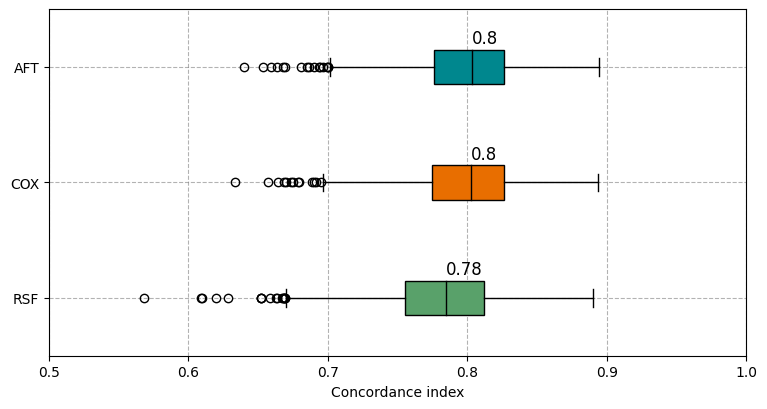

In [ ]:
df = pd.DataFrame([C_Idx_aft, C_Idx_cph, C_Idx_rsf], index=['AFT', 'CoxPH', 'RSF'])
df2 = df.transpose()

colors = ['#59A16A', '#E86E00', '#00878E']

aft_median = np.median(df2['AFT'])
cox_median = np.median(df2['CoxPH'])
rsf_median = np.median(df2['RSF'])
aft_std = np.std(df2['AFT'])
cox_std = np.std(df2['CoxPH'])
rsf_std = np.std(df2['RSF'])

plt.figure(figsize=(9,4.5))
C_Idx_Box = plt.boxplot(df2[[ 'RSF', 'CoxPH', 'AFT']].values, vert=False, patch_artist=True)
plt.yticks([1,2,3], ['RSF', 'COX', 'AFT'])

for box, color in zip(C_Idx_Box['boxes'], colors):
    box.set(facecolor=color)  # Custom box face color
    box.set(edgecolor='black')  # Custom edge color

for median in C_Idx_Box['medians']:
    median.set(color='black')

plt.annotate(str(np.round(aft_median,2)), xy=(aft_median, 0.8)
                , xytext=(aft_median, 3.205) , fontsize=12)
plt.annotate(str(np.round(cox_median,2)), xy=(aft_median, 0.8)
                , xytext=(cox_median, 2.205) , fontsize=12)
plt.annotate(str(np.round(rsf_median,2)), xy=(aft_median, 0.8)
                , xytext=(rsf_median, 1.205) , fontsize=12)
plt.xlim([0.5,1.0])
plt.xlabel('Concordance index')
plt.grid(axis='both', linestyle='--', color='gray', alpha=0.6)
plt.show()

In [ ]:
print(aft_median)
print(cox_median)
print(rsf_median)
print(aft_std)
print(cox_std)
print(rsf_std)

0.80327834
0.8024120349999999
0.784856765
0.039234109420089244
0.039600204290983626
0.04410536185250775


## Visualization along with Internal validation results

In [ ]:
#Bring the result of 'Model evaluation.ipynb' results

#C-index result of AFT
Int_aft = [0.8623681 , 0.86158098, 0.82848787, 0.87291362, 0.85942752,
       0.83035233, 0.86410888, 0.88398291, 0.85489767, 0.86937883,
       0.85052886, 0.84398377, 0.82839407, 0.84964604, 0.85036036,
       0.84163311, 0.85490049, 0.83460873, 0.85575944, 0.88355418,
       0.83531151, 0.85755336, 0.82003377, 0.85097158, 0.84437588,
       0.85913737, 0.87241625, 0.84446339, 0.84622837, 0.85217193,
       0.87962658, 0.85418222, 0.84358886, 0.84074092, 0.84830582,
       0.86129992, 0.85661285, 0.83327616, 0.84979296, 0.85665446,
       0.85487505, 0.85171046, 0.8412365 , 0.84000871, 0.86029247,
       0.85127982, 0.83524074, 0.85387304, 0.85019881, 0.83568684]

#C-index result of COX
Int_cph = [0.86138387, 0.86033415, 0.8269714 , 0.87202691, 0.85934874,
       0.82483952, 0.86364154, 0.88377789, 0.85442267, 0.86783683,
       0.84982219, 0.8430869 , 0.82720515, 0.85176758, 0.84796171,
       0.84044407, 0.85291025, 0.83443792, 0.8536116 , 0.88236295,
       0.83204431, 0.85750949, 0.82101879, 0.84898529, 0.84377169,
       0.85987285, 0.8715451 , 0.84530247, 0.84687428, 0.84987426,
       0.87995607, 0.85447828, 0.84188152, 0.83956486, 0.84692659,
       0.86297874, 0.85517234, 0.83453402, 0.84594227, 0.8544359 ,
       0.85288289, 0.85077729, 0.84107589, 0.84000871, 0.85955233,
       0.849745  , 0.83404521, 0.85306302, 0.85075171, 0.8364486 ]

#C-index result of RSF
Int_rsf = [0.84964179, 0.84755413, 0.82705806, 0.87231379, 0.85491071,
       0.82616259, 0.85382757, 0.88484613, 0.84921831, 0.85409011,
       0.83546093, 0.85199454, 0.82471466, 0.84850284, 0.8402027 ,
       0.84092675, 0.85457504, 0.83870821, 0.84535545, 0.87148303,
       0.8250707 , 0.85086315, 0.8256841 , 0.8545242 , 0.84710117,
       0.86173024, 0.85303318, 0.84462321, 0.83550173, 0.84490169,
       0.87531576, 0.85989754, 0.8485161 , 0.82841672, 0.84222415,
       0.85832446, 0.84425975, 0.82652945, 0.83242984, 0.84571927,
       0.84805374, 0.85060762, 0.83604734, 0.82633126, 0.83956847,
       0.83883209, 0.83881713, 0.85586336, 0.84878714, 0.83850649]

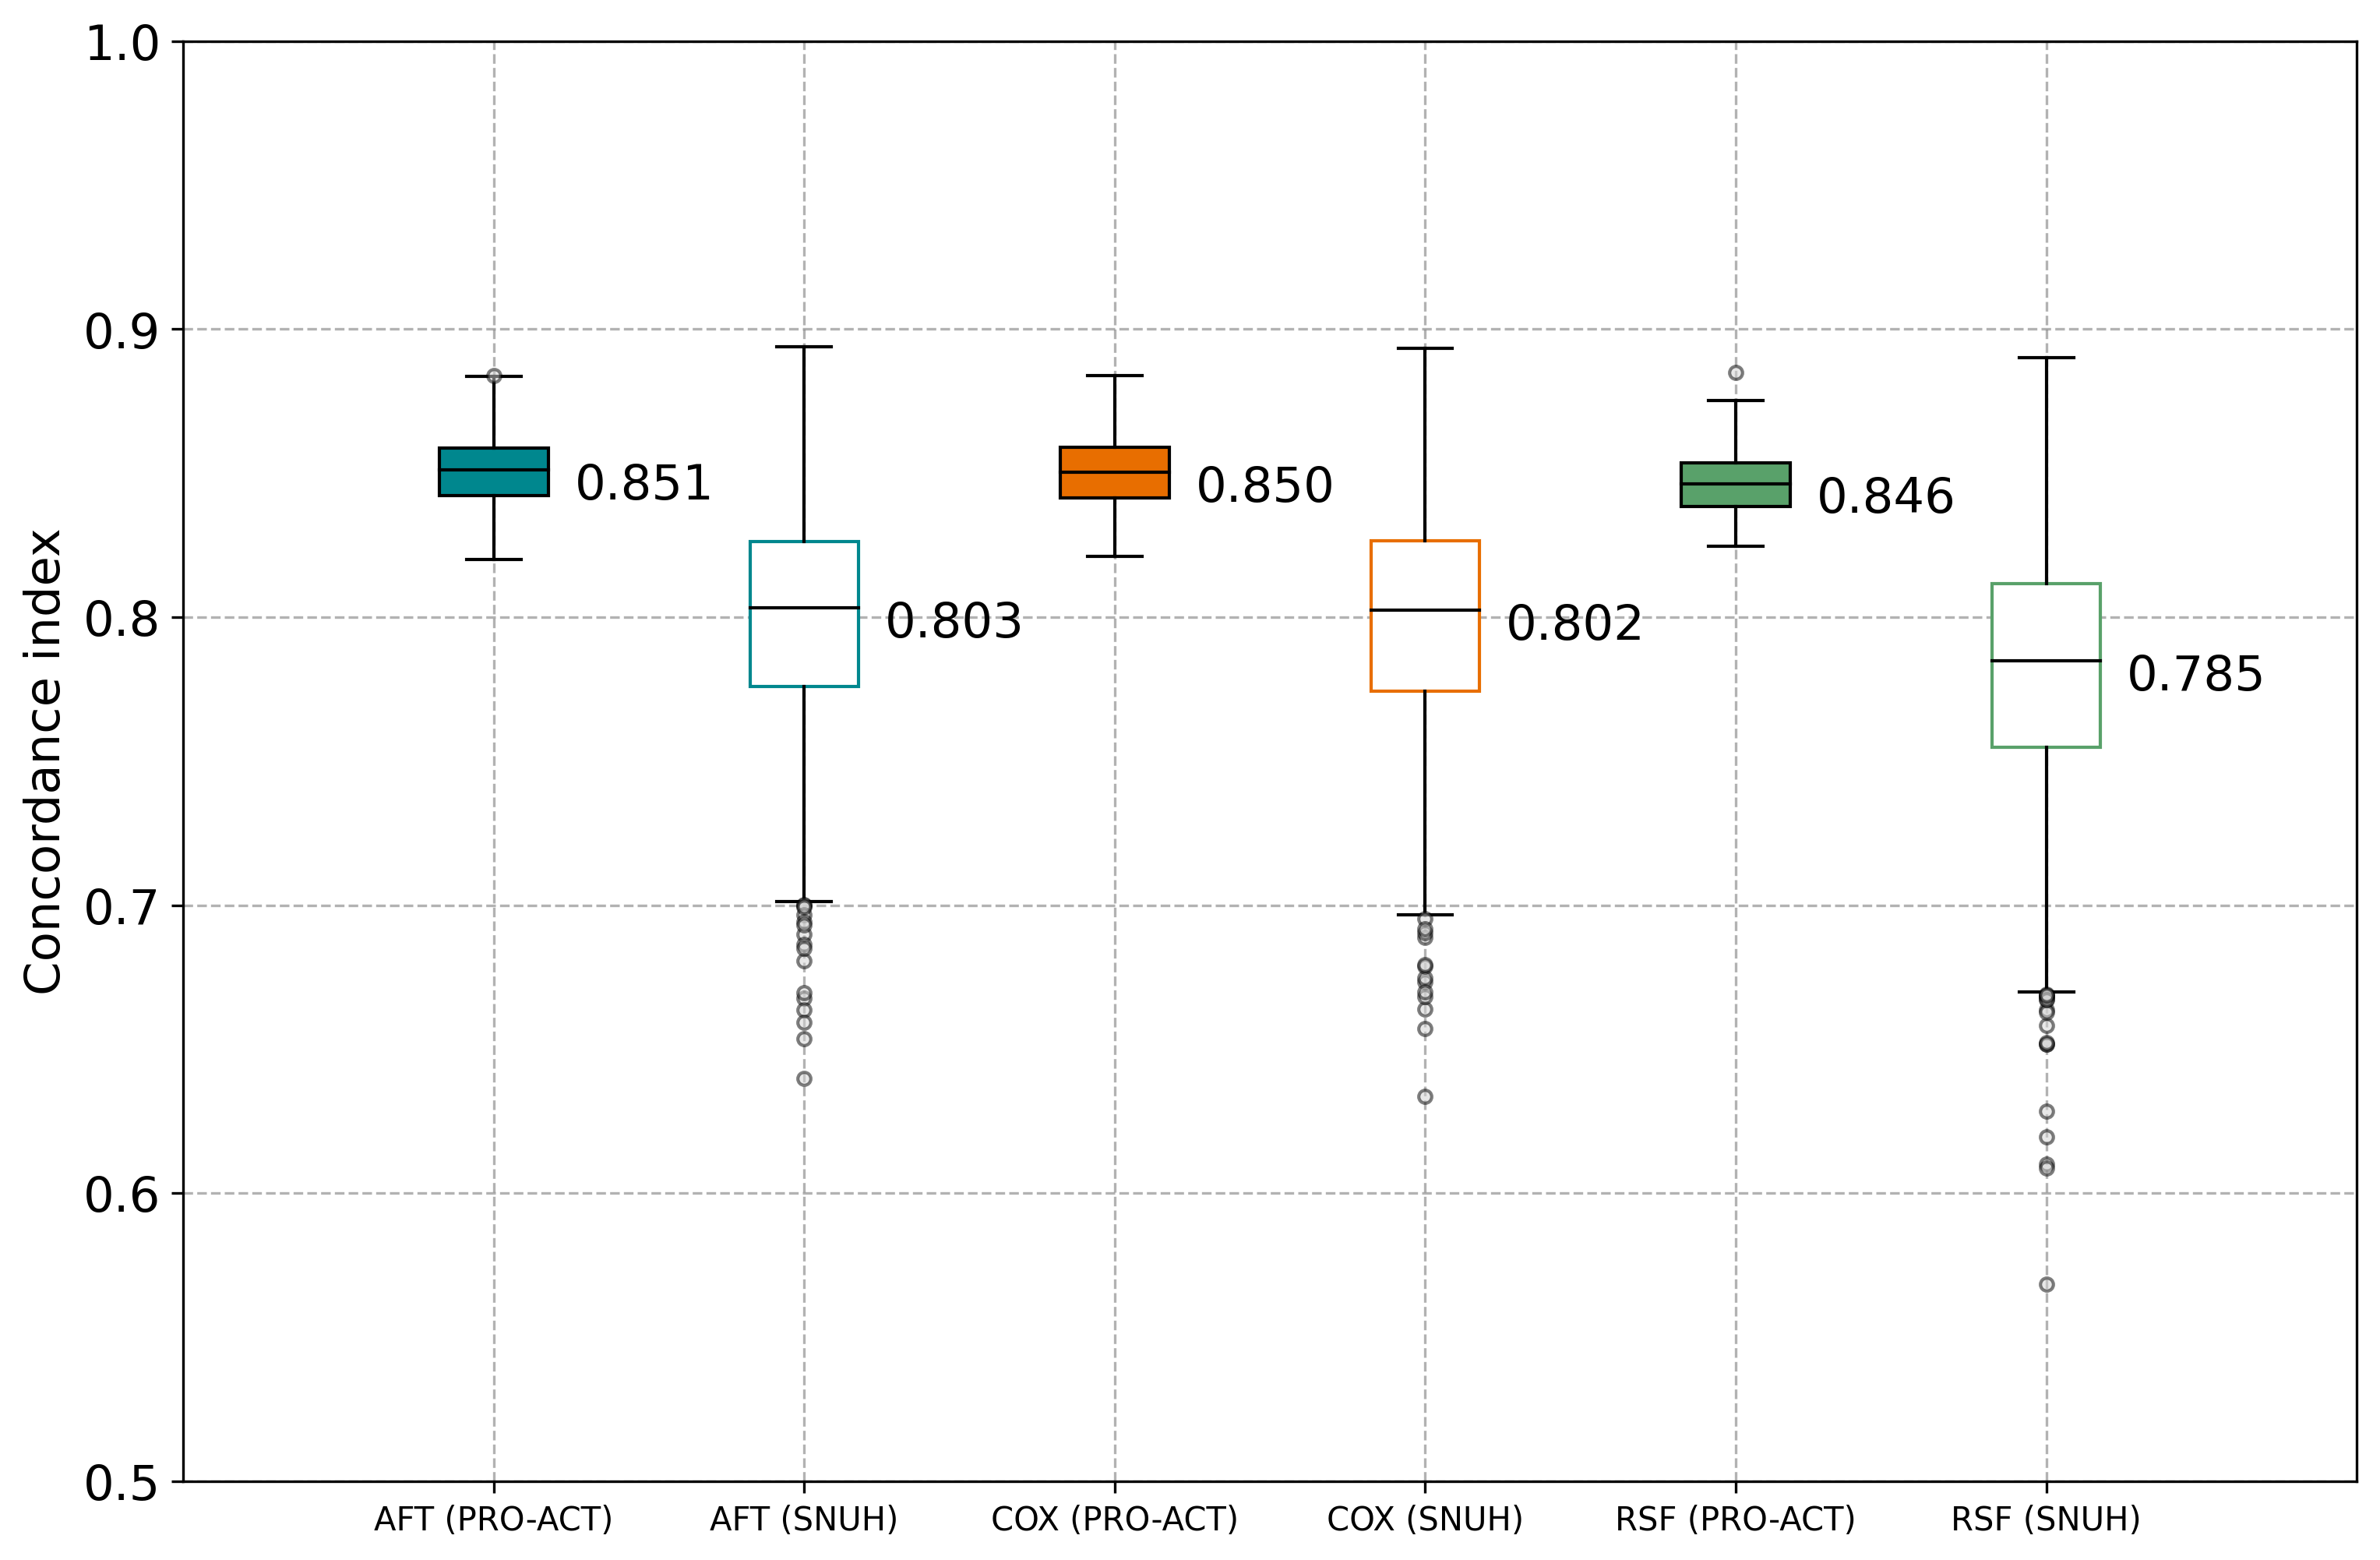

In [ ]:
df_i = pd.DataFrame([Int_aft, Int_cph, Int_rsf], index=['AFT', 'CoxPH', 'RSF'])
df = pd.DataFrame([C_Idx_aft, C_Idx_cph, C_Idx_rsf], index=['AFT', 'CoxPH', 'RSF'])
df_i2 = df_i.transpose()
df2 = df.transpose()

colors_i = ['#00878E', '#E86E00', '#59A16A']
colors = ['#BEE3FE','#FFB775','#ABD1B4']

aft_i_median = np.median(df_i2['AFT'])
cox_i_median = np.median(df_i2['CoxPH'])
rsf_i_median = np.median(df_i2['RSF'])
aft_median = np.median(df2['AFT'])
cox_median = np.median(df2['CoxPH'])
rsf_median = np.median(df2['RSF'])
aft_i_std = np.std(df_i2['AFT'])
cox_i_std = np.std(df_i2['CoxPH'])
rsf_i_std = np.std(df_i2['RSF'])
aft_std = np.std(df2['AFT'])
cox_std = np.std(df2['CoxPH'])
rsf_std = np.std(df2['RSF'])

fig, ax = plt.subplots(figsize=(12,8))

boxplot1 = ax.boxplot(df2[[ 'AFT', 'CoxPH', 'RSF']].values, vert=True, patch_artist=True, positions = [2,4,6], widths = 0.35)
boxplot2 = ax.boxplot(df_i2[[ 'AFT', 'CoxPH', 'RSF']].values, vert=True, patch_artist=True, positions = [1,3,5], widths = 0.35)

plt.xticks([6,5, 4,3, 2,1], ['RSF (SNUH)', 'RSF (PRO-ACT)','COX (SNUH)','COX (PRO-ACT)', 'AFT (SNUH)', 'AFT (PRO-ACT)'])

for box, color in zip(boxplot1['boxes'], colors_i):
    box.set(facecolor='w')  # Custom box face color
    box.set(edgecolor=color)  # Custom edge color

for box, color in zip(boxplot2['boxes'], colors_i):
    box.set(facecolor=color)  # Custom box face color
    box.set(edgecolor='k')  # Custom edge color

for median in boxplot1['medians']:
    median.set(color='black')

for median in boxplot2['medians']:
    median.set(color='black')

# Customize the appearance of the outliers
outlier_marker = dict(markerfacecolor='#d3d3d3', marker='o', markersize=4, alpha=0.5)
for flier in boxplot1['fliers']:
    flier.set(**outlier_marker)
for flier in boxplot2['fliers']:
    flier.set(**outlier_marker)

plt.annotate(str(f"{aft_median:.3f}"), xy=(aft_median, 0.8)
                , xytext=(2.26, aft_median-0.01) , fontsize=15)
plt.annotate(str(f"{aft_i_median:.3f}"), xy=(aft_i_median, 0.8)
                , xytext=( 1.26, aft_i_median-0.01) , fontsize=15)
plt.annotate(str(f"{cox_median:.3f}"), xy=(aft_median, 0.8)
                , xytext=( 4.26, cox_median-0.01) , fontsize=15)
plt.annotate(str(f"{cox_i_median:.3f}"), xy=(cox_i_median, 0.8)
                , xytext=( 3.26, cox_i_median-0.01) , fontsize=15)
plt.annotate(str(f"{rsf_median:.3f}"), xy=(aft_median, 0.8)
                , xytext=( 6.26, rsf_median-0.01) , fontsize=15)
plt.annotate(str(f"{rsf_i_median:.3f}"), xy=(rsf_i_median, 0.8)
                , xytext=( 5.26, rsf_i_median-0.01) , fontsize=15)

plt.ylim([0.5,1.0])
plt.xlim([0, 7])
plt.ylabel('Concordance index', fontsize=15)
plt.grid(axis='both', linestyle='--', color='gray', alpha=0.6)
plt.yticks(fontsize=15)
plt.xticks()
plt.show()

In [ ]:
from scipy import stats

ttest_aft = stats.ttest_ind(C_Idx_aft, np.array(Int_aft), equal_var=False)
ttest_cph = stats.ttest_ind(C_Idx_cph, np.array(Int_cph), equal_var=False)
ttest_rsf = stats.ttest_ind(C_Idx_rsf, np.array(Int_rsf), equal_var=False)

if ttest_aft.pvalue<0.05:
  aft_p = '<0.05'
else :
  aft_p = ttest_aft.pvalue

if ttest_cph.pvalue<0.05:
  cph_p = '<0.05'
else :
  cph_p = ttest_cph.pvalue

if ttest_rsf.pvalue<0.05:
  rsf_p = '<0.05'
else :
  rsf_p = ttestrsf.pvalue

print("AFT Model: t-statistic = {}, p-value {}".format(ttest_aft.statistic, aft_p))
print("COX Model: t-statistic = {}, p-value {}".format(ttest_cph.statistic, cph_p))
print("RSF Model: t-statistic = {}, p-value {}".format(ttest_rsf.statistic, rsf_p))

AFT Model: t-statistic = -22.204792482879995, p-value <0.05
COX Model: t-statistic = -21.87230208740152, p-value <0.05
RSF Model: t-statistic = -27.229874447612392, p-value <0.05


## 2-2. D-calibration

In [ ]:
def d_calibration_table(model, data, feature_list):
  global bin_cs
  df_occurred = data.query('status_LOA == 1')
  df_censored = data.query('status_LOA == 0')
  calibration = pd.DataFrame(np.zeros((2, 10)))
  calibration.index = ['Occurred', 'Censored']
  calibration.columns = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

  if model == rsf:
    for i in range(len(df_occurred)):
      result = np.squeeze(model.predict_survival_function(df_occurred[feature_list].iloc[i, :].to_numpy().reshape(1, -1), return_array = True))
      time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })
      probability = time_result.iloc[(time_result['time']-df_occurred.iloc[i, :]['time_LOA']).abs().argsort()[:1]].iloc[0,1]
      bin = math.floor(probability*10)*10
      calibration.loc['Occurred'][bin] = calibration.loc['Occurred'][bin]+1

    for j in range(len(df_censored)):
      result_cs = np.squeeze(model.predict_survival_function(df_censored[feature_list].iloc[j, :].to_numpy().reshape(1, -1), return_array = True))
      time_result_cs = pd.DataFrame({'time' : rsf.event_times_, 'p' : result_cs })
      probability_cs = time_result_cs.iloc[(time_result_cs['time']-df_censored.iloc[j, :]['time_LOA']).abs().argsort()[:1]].iloc[0,1]
      if probability_cs == 1:
        bins_cs = 90
      else :
        bin_cs = math.floor(probability_cs*10)*10
      calibration.loc['Censored'][bin_cs] = calibration.loc['Censored'][bin_cs]+(1-(0.01*bin_cs/probability_cs))

      for k in range(0,bin_cs,10):
        calibration.loc['Censored'][k] = calibration.loc['Censored'][k]+(0.1/probability_cs)

  else :
    for i in range(len(df_occurred)):
      pred_curve = model.predict_survival_function(df_occurred[feature_list].iloc[i, :]).reset_index()
      probability = pred_curve.iloc[(pred_curve['index']-df_occurred.iloc[i, :]['time_LOA']).abs().argsort()[:1]].iloc[0,1]
      bin = math.floor(probability*10)*10
      calibration.loc['Occurred'][bin] = calibration.loc['Occurred'][bin]+1

    for j in range(len(df_censored)):
      pred_curve_cs = model.predict_survival_function(df_censored[feature_list].iloc[j, :]).reset_index()
      probability_cs = pred_curve_cs.iloc[(pred_curve_cs['index']-df_censored.iloc[j, :]['time_LOA']).abs().argsort()[:1]].iloc[0,1]
      if probability_cs == 1:
        bins_cs = 90
      else :
        bin_cs = math.floor(probability_cs*10)*10
      calibration.loc['Censored'][bin_cs] = calibration.loc['Censored'][bin_cs]+(1-(0.01*bin_cs/probability_cs))

      for k in range(0,bin_cs,10):
        calibration.loc['Censored'][k] = calibration.loc['Censored'][k]+(0.1/probability_cs)

  calibration = np.transpose(calibration)
  calibration['Total'] = calibration['Occurred'] + calibration['Censored']
  quantile_list = ['[0%-10%)','[10%-20%)','[20%-30%)','[30%-40%)','[40%-50%)','[50%-60%)','[60%-70%)','[70%-80%)','[80%-90%)','[90%-100%]']
  calibration.index = quantile_list
  return calibration

In [ ]:
#CAUTION! Runtime takes 2 mins
aft_d_cal_full_result = d_calibration_table(aft, snuh_imputed_scaled, aft_feature_list)
cph_d_cal_full_result = d_calibration_table(cph, snuh_imputed_scaled, cph_feature_list)
rsf_d_cal_full_result = d_calibration_table(rsf, snuh_imputed, rsf_feature_list)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not 

Chi-square goodness of fit test : check uniformity

In [ ]:
from scipy.stats import chisquare

In [ ]:
def chi_test(table, data):
  chi_df = (table/len(data)*100)[['Total']]
  chi_df['exp'] = 10
  chi_df.columns = ['obs', 'exp']
  chi_df = np.transpose(chi_df)
  chi_result = chisquare(np.array(chi_df.loc['obs']))

  return chi_result

In [ ]:
# Chi-square statistics
print("AFT : ", chi_test(aft_d_cal_full_result, snuh_imputed_scaled))
#AFT : stats = 7.3814, pvalue = 0.5975
print("COX : ", chi_test(cph_d_cal_full_result, snuh_imputed_scaled))
#COX : stats = 7.1030, pvalue = 0.6264
print("RSF : ", chi_test(rsf_d_cal_full_result, snuh_imputed))
#RSF : stats = 7.3337, pvalue =0.6024

AFT :  Power_divergenceResult(statistic=11.000410911231203, pvalue=0.2756807719313079)
COX :  Power_divergenceResult(statistic=11.05264769950885, pvalue=0.2721174671665368)
RSF :  Power_divergenceResult(statistic=5.45854886475438, pvalue=0.7926452035720546)


<Figure size 2400x3000 with 0 Axes>

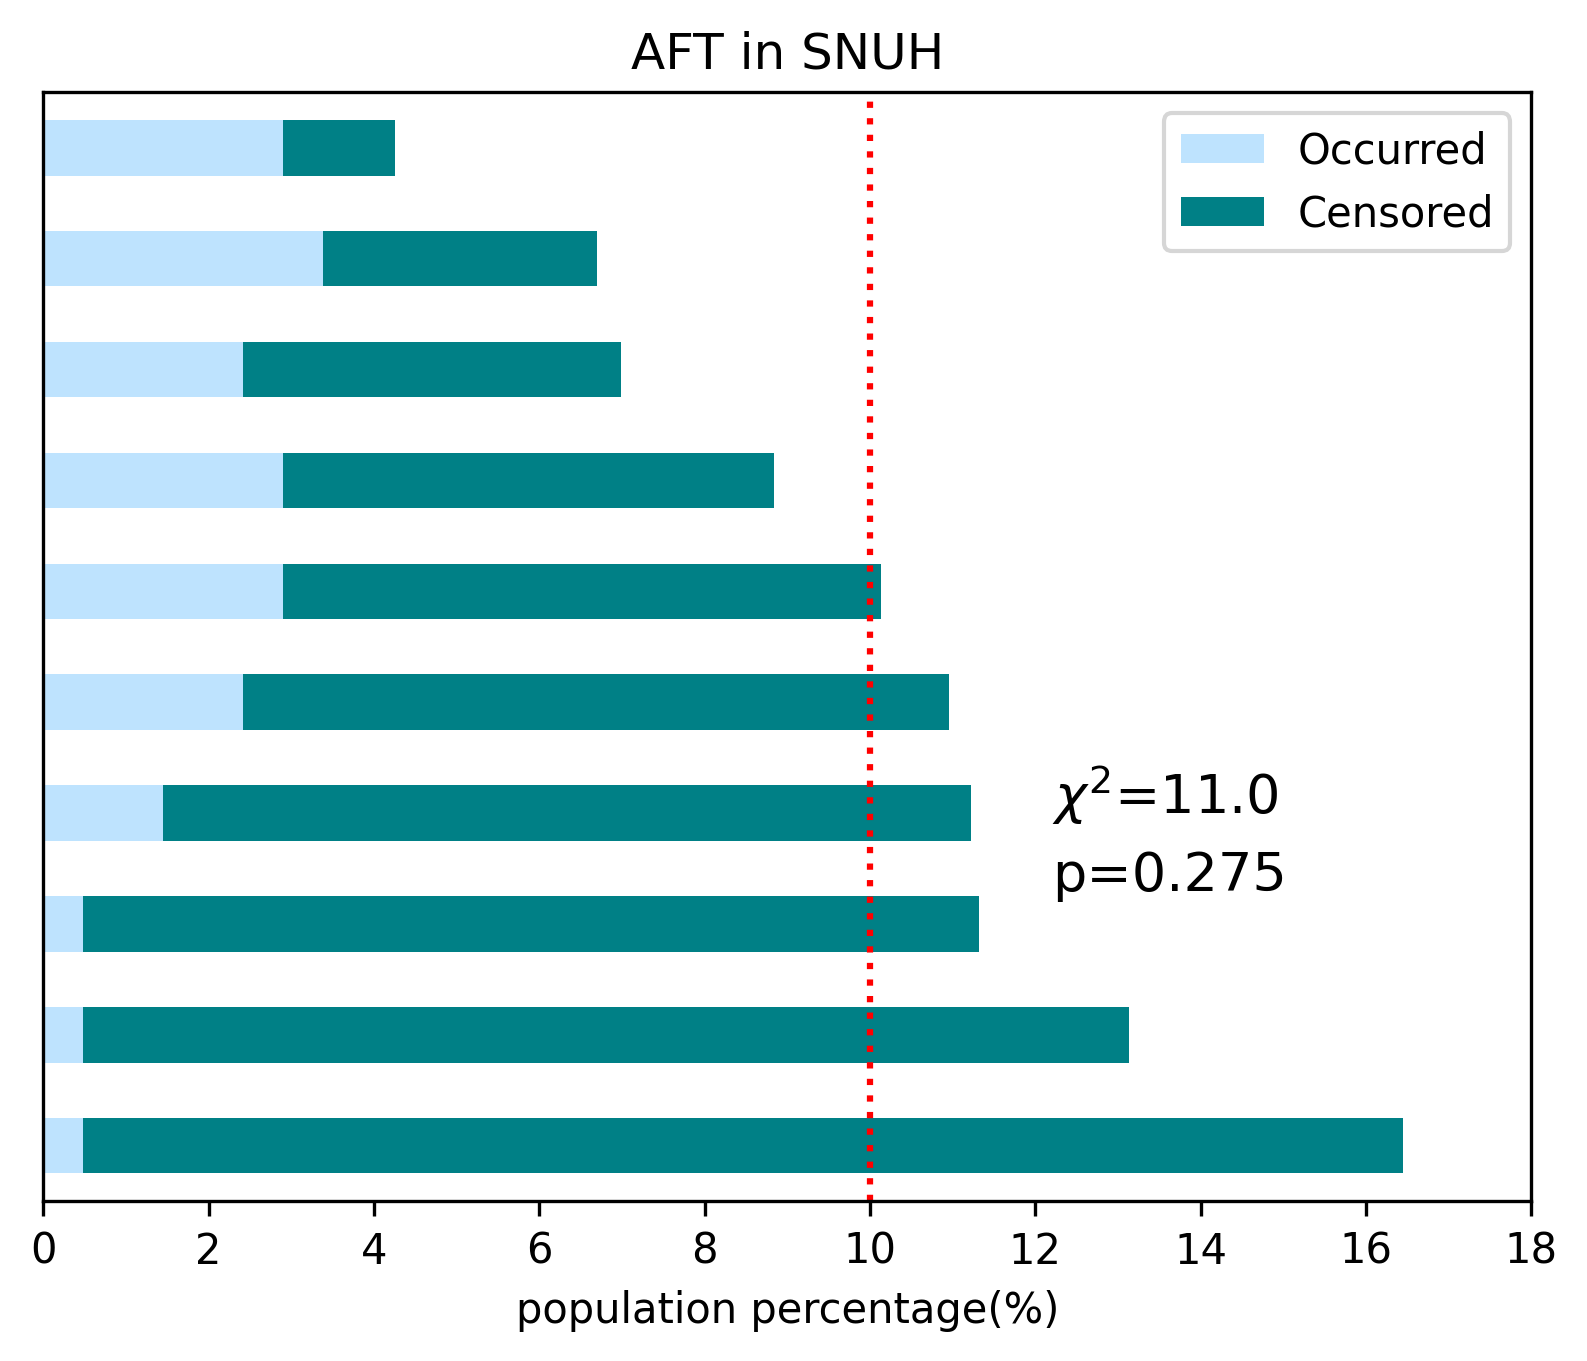

<Figure size 2400x3000 with 0 Axes>

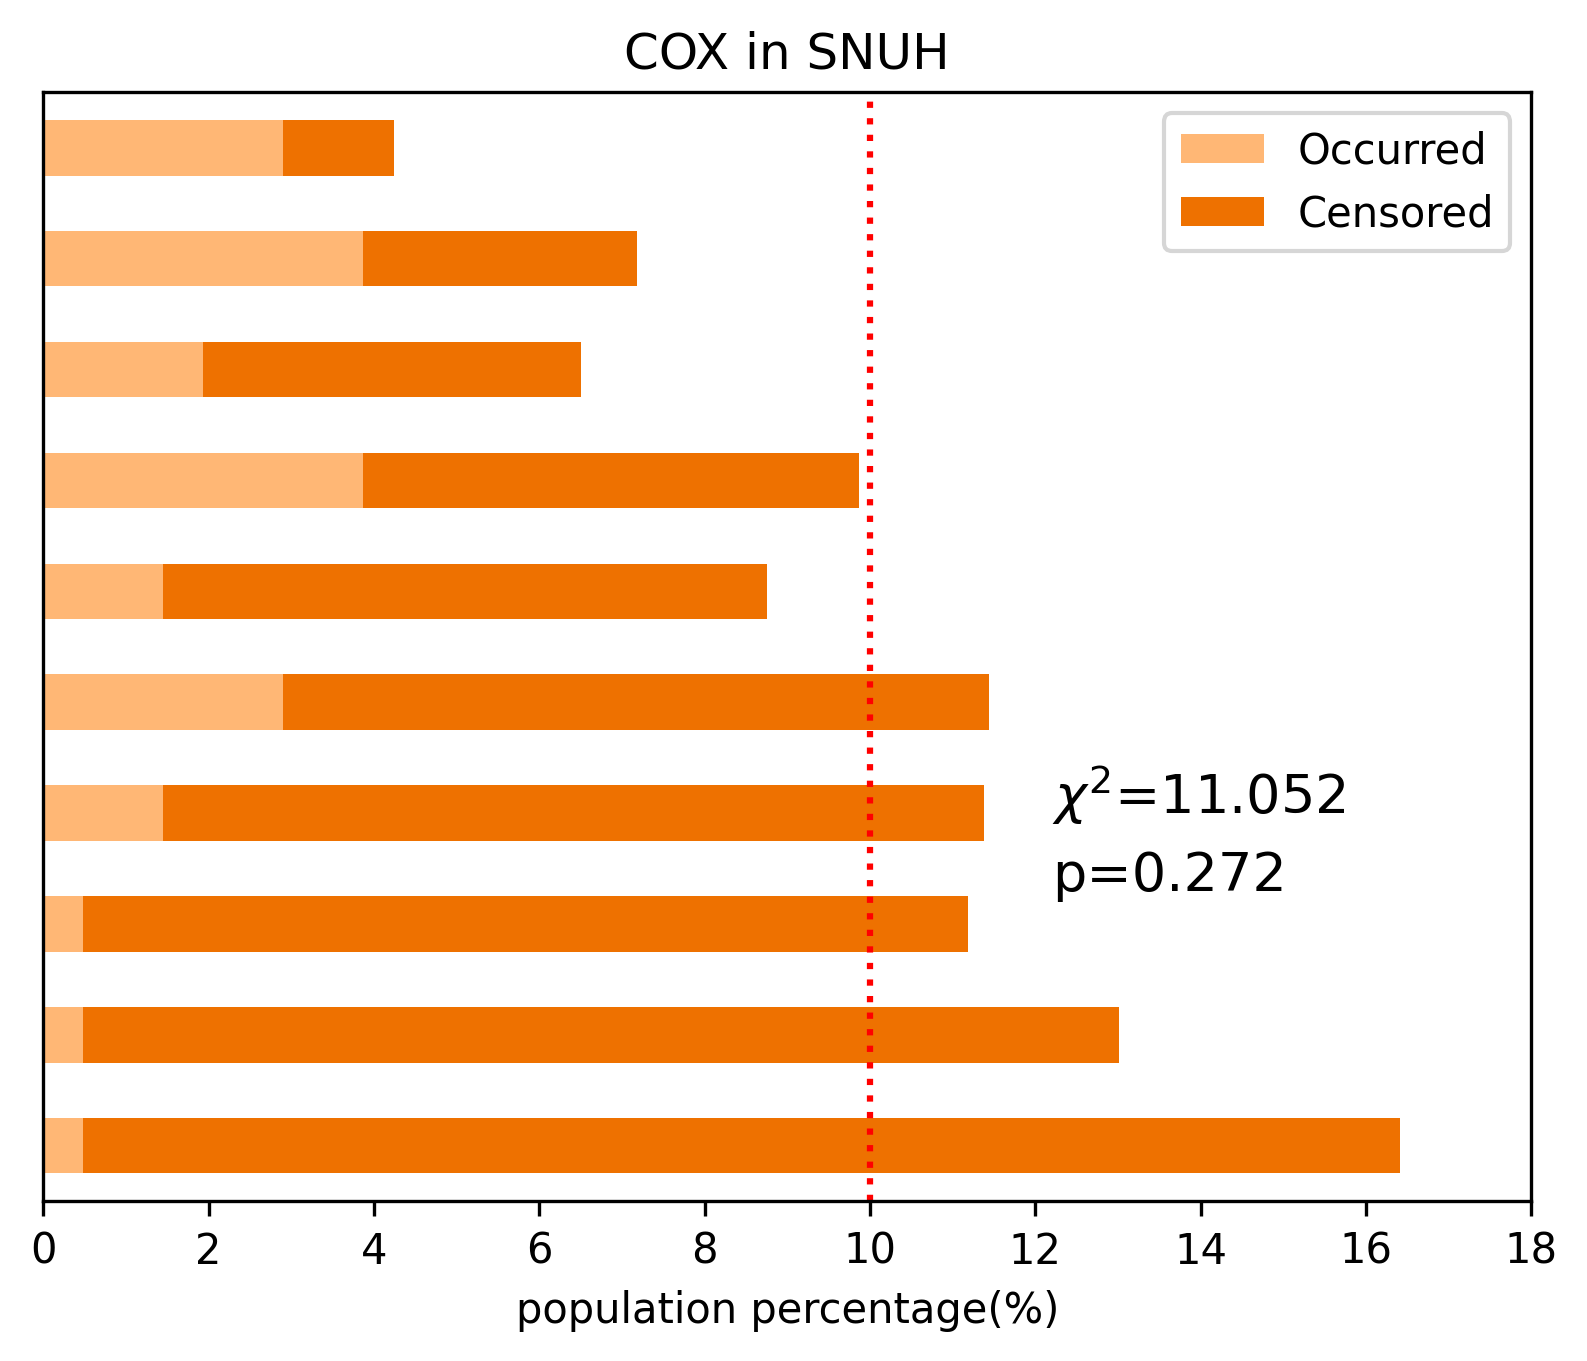

<Figure size 2400x3000 with 0 Axes>

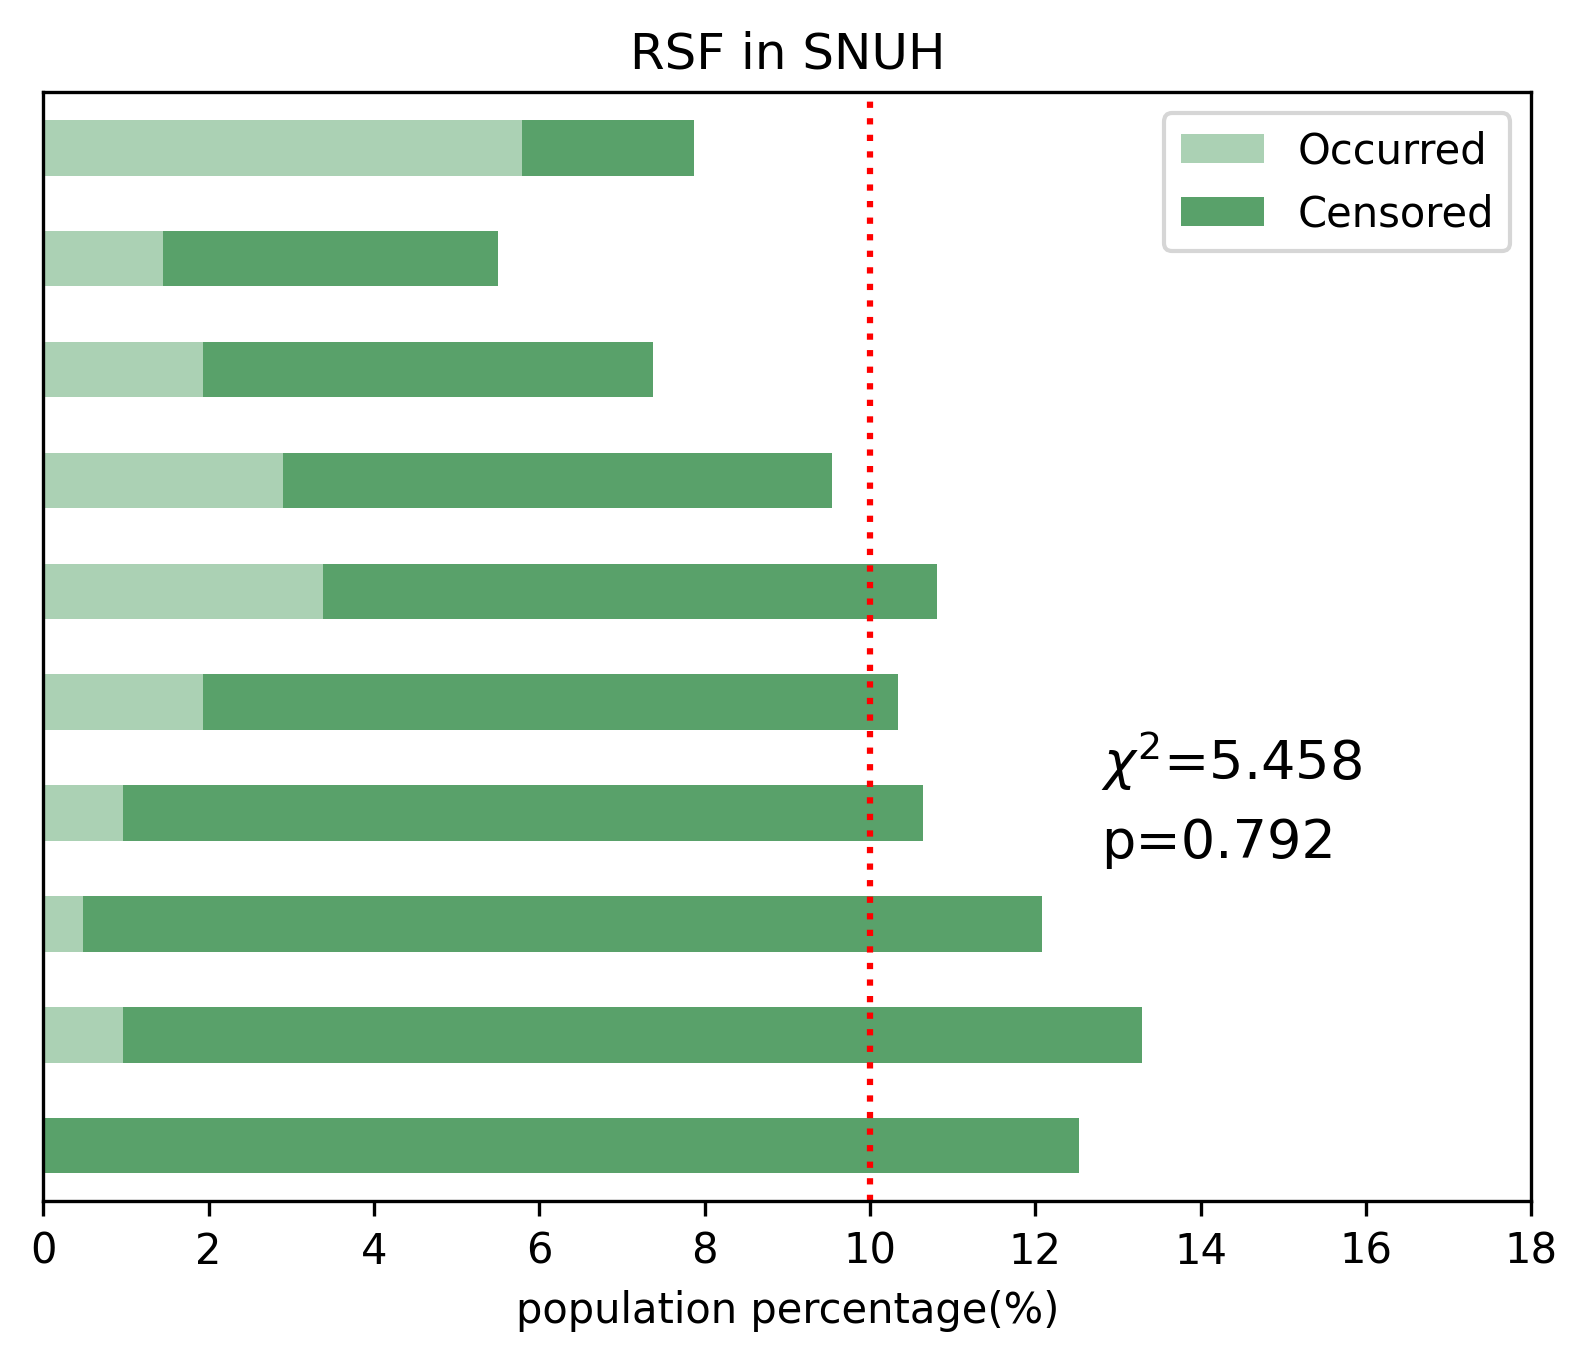

In [ ]:
plt.figure(figsize=(8,10))
(aft_d_cal_full_result/2.07)[['Occurred', 'Censored']].plot(kind='barh', stacked=True, color=['#BEE3FE','#008086']) # the number '2.07' is because the length of training data is 210
plt.title('AFT in SNUH')
plt.xlim([0,18])
plt.axvline(x=10, color='red', linestyle=':')
plt.text(12.2, 3, '$\chi^2$=' + str(np.floor(chi_test(aft_d_cal_full_result, snuh_imputed_scaled)[0]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.text(12.2, 2.3, 'p=' + str(np.floor(chi_test(aft_d_cal_full_result, snuh_imputed_scaled)[1]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.xlabel('population percentage(%)')
plt.yticks([])

plt.figure(figsize=(8,10))
(cph_d_cal_full_result/2.07)[['Occurred', 'Censored']].plot(kind='barh', stacked=True, color=['#FFB775','#EE7100'])
plt.title('COX in SNUH')
plt.xlabel('population percentage(%)')
plt.ylabel('')
plt.xlim([0,18])
plt.axvline(x=10, color='red', linestyle=':')
plt.text(12.2, 3, '$\chi^2$=' + str(np.floor(chi_test(cph_d_cal_full_result, snuh_imputed_scaled)[0]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.text(12.2, 2.3, 'p=' + str(np.floor(chi_test(cph_d_cal_full_result, snuh_imputed_scaled)[1]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.yticks([])

plt.figure(figsize=(8,10))
(rsf_d_cal_full_result/2.07)[['Occurred', 'Censored']].plot(kind='barh', stacked=True, color=['#ABD1B4','#59A16A'])
plt.title('RSF in SNUH')
plt.xlabel('population percentage(%)')
plt.ylabel('')
plt.xlim([0,18])
plt.axvline(x=10, color='red', linestyle=':')
plt.text(12.8, 3.3, '$\chi^2$=' + str(np.floor(chi_test(rsf_d_cal_full_result, snuh_imputed)[0]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.text(12.8, 2.6, 'p=' + str(np.floor(chi_test(rsf_d_cal_full_result, snuh_imputed)[1]*1000)/1000),
         horizontalalignment='left', color='black', fontsize = 13)
plt.yticks([])

plt.show()